In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# extract_tables.py
# Modified to support both HTML and XML files
# Usage in Jupyter: run this cell (it will prompt if multiple files exist)

def list_data_files(folder='.'):
    """List both HTML and XML files in the folder"""
    html_files = sorted(glob.glob(os.path.join(folder, '*.html')) + glob.glob(os.path.join(folder, '*.htm')))
    xml_files = sorted(glob.glob(os.path.join(folder, '*.xml')))
    return html_files, xml_files

def choose_file(html_files, xml_files):
    """Prompt user to select a file (HTML or XML)"""
    if not html_files and not xml_files:
        raise FileNotFoundError("No HTML or XML files found in the current folder.")
    
    all_files = html_files + xml_files
    
    if len(all_files) == 1:
        return all_files[0]
    
    print("Found files:")
    for i, f in enumerate(all_files):
        file_type = "HTML" if f in html_files else "XML"
        print(f"{i}: {f} ({file_type})")
    idx = input("Enter index of file to parse (default 0): ").strip() or "0"
    return all_files[int(idx)]

def extract_xml_drivers(xml_path):
    """Parse XML file and extract driver lap time data"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    child = root[0]
    subchild = child[-1]
    drivers_data = []
    # Print tree structure for debugging
    # print(f"Root tag: {root.tag}")  # Debug: print root tag to verify XML structure
    # print(f"Child tags: {[child.tag for child in root]}")  # Debug: print child tags to understand XML structure
    # print(f'child sub tags: {[subchild.tag for subchild in child]}')  # Debug: print subchild tags to find where Driver elements are
    # print(f"Number of 'Driver' elements found in {subchild.tag}: {len(subchild.findall('Driver'))}")  # Debug: count Driver elements
    
    for driver_elem in subchild.findall('Driver'):
        driver_info = {}
        driver_info['Driver'] = driver_elem.findtext('Name', 'Unknown')
        driver_info['Car'] = driver_elem.findtext('CarType', 'Unknown')
        driver_info['CarNumber'] = driver_elem.findtext('CarNumber', 'N/A')
        driver_info['Position'] = driver_elem.findtext('Position', 'N/A')
        driver_info['BestLapTime'] = driver_elem.findtext('BestLapTime', '')
        driver_info['Laps'] = driver_elem.findtext('Laps', '0')
        driver_info['FinishStatus'] = driver_elem.findtext('FinishStatus', '')
        
        # Convert best lap time from float to MM:SS format if available
        try:
            best_lap_float = float(driver_info['BestLapTime'])
            minutes = int(best_lap_float // 60)
            seconds = best_lap_float % 60
            driver_info['Best Lap'] = f"{minutes}:{seconds:06.3f}"
            driver_info['Best Lap  Laps'] = f"{minutes}:{seconds:06.3f}"
        except (ValueError, TypeError):
            if driver_info['BestLapTime']:
                driver_info['Best Lap'] = driver_info['BestLapTime']
                driver_info['Best Lap  Laps'] = driver_info['BestLapTime']
            else:
                driver_info['Best Lap'] = 'DNF'
                driver_info['Best Lap  Laps'] = 'DNF'
        
        drivers_data.append(driver_info)
    
    if drivers_data:
        return [pd.DataFrame(drivers_data)]
    else:
        print("No driver data found in XML file.")
        return []

def extract_with_bs4(path):
    """Legacy HTML extraction using BeautifulSoup"""
    from bs4 import BeautifulSoup
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        soup = BeautifulSoup(f, 'html.parser')
    tables = []
    for table in soup.find_all('table'):
        rows = []
        for tr in table.find_all('tr'):
            cells = tr.find_all(['th', 'td'])
            row = [cell.get_text(strip=True) for cell in cells]
            if row:
                rows.append(row)
        if rows:
            maxlen = max(len(r) for r in rows)
            rows = [r + ['']*(maxlen - len(r)) for r in rows]
            df = pd.DataFrame(rows)
            if len(df) > 1 and all(isinstance(x, str) for x in df.iloc[0]):
                df.columns = df.iloc[0]
                df = df[1:].reset_index(drop=True)
            tables.append(df)
    return tables

def load_data_file(file_path):
    """Load data from either HTML or XML file"""
    if file_path.lower().endswith('.xml'):
        return extract_xml_drivers(file_path)
    else:
        # Try pandas first, then fallback to BeautifulSoup for HTML
        try:
            tables = pd.read_html(file_path)
            return tables
        except Exception:
            return extract_with_bs4(file_path)

In [2]:
# Load XML files
file1_path = '../xml/sprint/s3-sc1.xml'
file2_path = '../xml/sprint/s3-sc2.xml'
file3_path = '../xml/sprint/s3-sc3.xml'  
file4_path = '../xml/sprint/s3-sc4.xml'  
file5_path = '../xml/sprint/s3-sc5.xml'  

# Load the files with automatic format detection
tables1 = load_data_file(file1_path)
tables2 = load_data_file(file2_path)
tables3 = load_data_file(file3_path)
tables4 = load_data_file(file4_path)
tables5 = load_data_file(file5_path)

print(f"Loaded {len(tables1)} table(s) from {file1_path}")
print(f"Loaded {len(tables2)} table(s) from {file2_path}")
print(f"Loaded {len(tables3)} table(s) from {file3_path}")
print(f"Loaded {len(tables4)} table(s) from {file4_path}")
print(f"Loaded {len(tables5)} table(s) from {file5_path}")

Loaded 1 table(s) from ../xml/sprint/s3-sc1.xml
Loaded 1 table(s) from ../xml/sprint/s3-sc2.xml
Loaded 1 table(s) from ../xml/sprint/s3-sc3.xml
Loaded 1 table(s) from ../xml/sprint/s3-sc4.xml
Loaded 1 table(s) from ../xml/sprint/s3-sc5.xml


In [3]:
alien_pace_sc1 = 103.14
alien_pace_sc2 = 235.31
alien_pace_sc3 = 93.65
alien_pace_sc4 = 99.01
alien_pace_sc5 = 120.17

In [4]:
# Process first data file (SC1)
df = tables1[0].copy()  # Use first table

# Convert lap times to seconds
def convert_laptime_to_seconds(laptime_str):
    """Convert laptime string (MM:SS.SSS or float) to seconds"""
    if pd.isna(laptime_str) or laptime_str == '' or laptime_str == 'DNF':
        return 0.0
    
    str_val = str(laptime_str).strip()
    
    # Try to parse as MM:SS.SSS format
    if ':' in str_val:
        try:
            parts = str_val.split(':')
            minutes = float(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        except (ValueError, IndexError):
            return 0.0
    
    # Try to parse as plain float
    try:
        return float(str_val)
    except ValueError:
        return 0.0

df['laptime_sec'] = df['Best Lap  Laps'].apply(convert_laptime_to_seconds)
df['Driver_name'] = df['Driver'].apply(lambda x: str(x).split('LMGT3')[0].strip() if 'LMGT3' in str(x) else str(x).strip())
df1_sc1 = df.copy()
df1_sc1['laptime_pct'] = round(df1_sc1[df1_sc1['laptime_sec']>0]['laptime_sec'].min()/df1_sc1['laptime_sec']*100 if len(df1_sc1[df1_sc1['laptime_sec']>0]) > 0 else 100, 2)
# Recalculate with proper filtering
min_laptime = df1_sc1[df1_sc1['laptime_sec']>0]['laptime_sec'].min()
df1_sc1['laptime_pct'] = round(min_laptime/df1_sc1['laptime_sec']*100, 2) if min_laptime > 0 else 100

ref_laptime_1 = alien_pace_sc1  # Use actual best laptime as reference
df1_sc1['laptime_pct_alien'] = round(df1_sc1['laptime_sec'] / ref_laptime_1 * 100, 2) if ref_laptime_1 > 0 else 100

print("Data from first file:")
print(df1_sc1[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].head(10))


Data from first file:
      Driver_name  laptime_sec  laptime_pct  laptime_pct_alien
0    Joris Butkus      104.176       100.00             101.00
1  Jacob Palmieri      104.200        99.98             101.03
2  Dakota Botello      105.169        99.06             101.97
3  Michael Landry      105.183        99.04             101.98
4  Donovan Bailey      105.199        99.03             102.00
5       Greg Kach      105.215        99.01             102.01
6    Cyril Fortin      105.261        98.97             102.06
7  Willie Mangram      105.389        98.85             102.18
8  Jeffrey Aroyan      105.468        98.77             102.26
9      Josh Popov      105.604        98.65             102.39


In [5]:
df1_sc1.replace({'Greg Kach': 'Greg Kachadurian'}, inplace=True)
df1_sc1.replace({'R McLean': 'Ross McLean'}, inplace=True)
df1_sc1.replace({'Ricky Swaby': 'Ricardo Swaby'}, inplace=True)
df1_sc1.replace({'p thomas': 'Parker Thomas'}, inplace=True)
df1_sc1.replace({'David Carter': 'Dave Carter'}, inplace=True)
df1_sc1.replace({'John P': 'John Pflibsen'}, inplace=True)
df1_sc1

,Driver,Car,CarNumber,Position,BestLapTime,Laps,FinishStatus,Best Lap,Best Lap Laps,laptime_sec,Driver_name,laptime_pct,laptime_pct_alien
0,Joris Butkus,Porsche 911 GT3 R LMGT3,11,1,104.1759,18,Finished Normally,1:44.176,1:44.176,104.176,Joris Butkus,100.00,101.00
1,Jacob Palmieri,Mercedes-AMG LMGT3,434,15,104.2002,18,Finished Normally,1:44.200,1:44.200,104.200,Jacob Palmieri,99.98,101.03
2,Dakota Botello,McLaren 720S LMGT3 Evo,33,3,105.1686,18,Finished Normally,1:45.169,1:45.169,105.169,Dakota Botello,99.06,101.97
3,Michael Landry,Lamborghini Huracan LMGT3 Evo2,710,7,105.1827,18,Finished Normally,1:45.183,1:45.183,105.183,Michael Landry,99.04,101.98
4,Donovan Bailey,BMW M4 LMGT3,13,4,105.1989,18,Finished Normally,1:45.199,1:45.199,105.199,Donovan Bailey,99.03,102.00
5,Greg Kachadurian,Ford Mustang LMGT3,123,2,105.2146,18,Finished Normally,1:45.215,1:45.215,105.215,Greg Kachadurian,99.01,102.01
6,Cyril Fortin,Porsche 911 GT3 R LMGT3,99,5,105.2609,18,Finished Normally,1:45.261,1:45.261,105.261,Cyril Fortin,98.97,102.06
7,Willie Mangram,Porsche 911 GT3 R LMGT3,2,9,105.3890,18,Finished Normally,1:45.389,1:45.389,105.389,Willie Mangram,98.85,102.18
8,Jeffrey Aroyan,Ferrari 296 LMGT3,233,6,105.4683,18,Finished Normally,1:45.468,1:45.468,105.468,Jeffrey Aroyan,98.77,102.26
9,Josh Popov,Ferrari 296 LMGT3,6,8,105.6044,18,Finished Normally,1:45.604,1:45.604,105.604,Josh Popov,98.65,102.39


In [6]:

# Process second data file (SC2)
df = tables2[0].copy()  # Use first table

df['laptime_sec'] = df['Best Lap  Laps'].apply(convert_laptime_to_seconds)
df['Driver_name'] = df['Driver'].apply(lambda x: str(x).split('LMGT3')[0].strip() if 'LMGT3' in str(x) else str(x).strip())
df1_sc2 = df.copy()

# Recalculate with proper filtering
min_laptime = df1_sc2[df1_sc2['laptime_sec']>0]['laptime_sec'].min()
df1_sc2['laptime_pct'] = round(min_laptime/df1_sc2['laptime_sec']*100, 2) if min_laptime > 0 else 100

ref_laptime_2 = alien_pace_sc2  # Use actual best laptime as reference
df1_sc2['laptime_pct_alien'] = round(df1_sc2['laptime_sec'] / ref_laptime_2 * 100, 2) if ref_laptime_2 > 0 else 100
df1_sc2.replace({'Ayrton Senna': 'Ayrton Torres'}, inplace=True)

print("Data from second file:")
print(df1_sc2[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].head(10))


Data from second file:
        Driver_name  laptime_sec  laptime_pct  laptime_pct_alien
0    Dakota Botello      239.253       100.00             101.68
1    Jeffrey Aroyan      239.489        99.90             101.78
2    Willie Mangram      239.799        99.77             101.91
3   Harrison Miller      240.818        99.35             102.34
4   Guillermo Paret      240.894        99.32             102.37
5      Cyril Fortin      241.184        99.20             102.50
6  Philippe Brazeau      241.867        98.92             102.79
7          R McLean      241.937        98.89             102.82
8    Alexandre Urie      242.019        98.86             102.85
9       Ricky Swaby      242.257        98.76             102.95


In [7]:
df1_sc2.replace({'Greg Kach': 'Greg Kachadurian'}, inplace=True)
df1_sc2.replace({'R McLean': 'Ross McLean'}, inplace=True)
df1_sc2.replace({'Ricky Swaby': 'Ricardo Swaby'}, inplace=True)
df1_sc2.replace({'p thomas': 'Parker Thomas'}, inplace=True)
df1_sc2.replace({'David Carter': 'Dave Carter'}, inplace=True)
df1_sc2.replace({'John P': 'John Pflibsen'}, inplace=True)
df1_sc2

,Driver,Car,CarNumber,Position,BestLapTime,Laps,FinishStatus,Best Lap,Best Lap Laps,laptime_sec,Driver_name,laptime_pct,laptime_pct_alien
0,Dakota Botello,McLaren 720S LMGT3 Evo,33,1,239.2532,8,Finished Normally,3:59.253,3:59.253,239.253,Dakota Botello,100.00,101.68
1,Jeffrey Aroyan,Ferrari 296 LMGT3,233,2,239.4888,8,Finished Normally,3:59.489,3:59.489,239.489,Jeffrey Aroyan,99.90,101.78
2,Willie Mangram,Porsche 911 GT3 R LMGT3,2,6,239.7991,8,Finished Normally,3:59.799,3:59.799,239.799,Willie Mangram,99.77,101.91
3,Harrison Miller,Ford Mustang LMGT3,17,7,240.8182,8,Finished Normally,4:00.818,4:00.818,240.818,Harrison Miller,99.35,102.34
4,Guillermo Paret,Chevrolet Corvette Z06 LMGT3.R,52,3,240.8937,8,Finished Normally,4:00.894,4:00.894,240.894,Guillermo Paret,99.32,102.37
5,Cyril Fortin,Porsche 911 GT3 R LMGT3,99,4,241.1841,8,Finished Normally,4:01.184,4:01.184,241.184,Cyril Fortin,99.20,102.50
6,Philippe Brazeau,McLaren 720S LMGT3 Evo,88,5,241.8667,8,Finished Normally,4:01.867,4:01.867,241.867,Philippe Brazeau,98.92,102.79
7,Ross McLean,Porsche 911 GT3 R LMGT3,93,21,241.9372,7,DNF,4:01.937,4:01.937,241.937,Ross McLean,98.89,102.82
8,Alexandre Urie,Porsche 911 GT3 R LMGT3,23,19,242.0193,8,Finished Normally,4:02.019,4:02.019,242.019,Alexandre Urie,98.86,102.85
9,Ricardo Swaby,McLaren 720S LMGT3 Evo,79,10,242.2567,8,Finished Normally,4:02.257,4:02.257,242.257,Ricardo Swaby,98.76,102.95


In [8]:

# Process third data file (SC3)
df = tables3[0].copy()  # Use first table

df['laptime_sec'] = df['Best Lap  Laps'].apply(convert_laptime_to_seconds)
df['Driver_name'] = df['Driver'].apply(lambda x: str(x).split('LMGT3')[0].strip() if 'LMGT3' in str(x) else str(x).strip())
df1_sc3 = df.copy()

# Recalculate with proper filtering
min_laptime = df1_sc3[df1_sc3['laptime_sec']>0]['laptime_sec'].min()
df1_sc3['laptime_pct'] = round(min_laptime/df1_sc3['laptime_sec']*100, 2) if min_laptime > 0 else 100

ref_laptime_3 = alien_pace_sc3  # Use actual best laptime as reference
df1_sc3['laptime_pct_alien'] = round(df1_sc3['laptime_sec'] / ref_laptime_3 * 100, 2) if ref_laptime_3 > 0 else 100

print("Data from third file:")
print(df1_sc3[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].head(10))


Data from third file:
        Driver_name  laptime_sec  laptime_pct  laptime_pct_alien
0      Joris Butkus       94.257       100.00             100.65
1         Greg Kach       94.442        99.80             100.85
2     Avinash Ganti       94.443        99.80             100.85
3      Cyril Fortin       94.675        99.56             101.09
4    Dakota Botello       94.731        99.50             101.15
5    Jeffrey Aroyan       94.737        99.49             101.16
6    Michael Landry       94.802        99.43             101.23
7    Willie Mangram       94.817        99.41             101.25
8    Donovan Bailey       94.960        99.26             101.40
9  Philippe Brazeau       95.231        98.98             101.69


In [9]:
df1_sc3.replace({'Greg Kach': 'Greg Kachadurian'}, inplace=True)
df1_sc3.replace({'R McLean': 'Ross McLean'}, inplace=True)
df1_sc3.replace({'Ricky Swaby': 'Ricardo Swaby'}, inplace=True)
df1_sc3.replace({'p thomas': 'Parker Thomas'}, inplace=True)
df1_sc3.replace({'David Carter#5529': 'Dave Carter'}, inplace=True)
df1_sc3.replace({'John P': 'John Pflibsen'}, inplace=True)
df1_sc3

,Driver,Car,CarNumber,Position,BestLapTime,Laps,FinishStatus,Best Lap,Best Lap Laps,laptime_sec,Driver_name,laptime_pct,laptime_pct_alien
0,Joris Butkus,Porsche 911 GT3 R LMGT3,85,1,94.2570,5,Finished Normally,1:34.257,1:34.257,94.257,Joris Butkus,100.00,100.65
1,Greg Kachadurian,Ford Mustang LMGT3,123,2,94.4420,7,Finished Normally,1:34.442,1:34.442,94.442,Greg Kachadurian,99.80,100.85
2,Avinash Ganti,Lexus RCF LMGT3,46,3,94.4429,7,Finished Normally,1:34.443,1:34.443,94.443,Avinash Ganti,99.80,100.85
3,Cyril Fortin,Porsche 911 GT3 R LMGT3,514,4,94.6755,7,Finished Normally,1:34.675,1:34.675,94.675,Cyril Fortin,99.56,101.09
4,Dakota Botello,McLaren 720S LMGT3 Evo,333,5,94.7307,7,Finished Normally,1:34.731,1:34.731,94.731,Dakota Botello,99.50,101.15
5,Jeffrey Aroyan,Ferrari 296 LMGT3,54,6,94.7372,6,Finished Normally,1:34.737,1:34.737,94.737,Jeffrey Aroyan,99.49,101.16
6,Michael Landry,Lamborghini Huracan LMGT3 Evo2,60,7,94.8015,5,Finished Normally,1:34.802,1:34.802,94.802,Michael Landry,99.43,101.23
7,Willie Mangram,Porsche 911 GT3 R LMGT3,2,8,94.8165,7,Finished Normally,1:34.817,1:34.817,94.817,Willie Mangram,99.41,101.25
8,Donovan Bailey,BMW M4 LMGT3,13,9,94.9596,7,Finished Normally,1:34.960,1:34.960,94.960,Donovan Bailey,99.26,101.40
9,Philippe Brazeau,McLaren 720S LMGT3 Evo,514,10,95.2315,7,Finished Normally,1:35.231,1:35.231,95.231,Philippe Brazeau,98.98,101.69


In [10]:

# Process fourth data file (SC4)
df = tables4[0].copy()  # Use first table

df['laptime_sec'] = df['Best Lap  Laps'].apply(convert_laptime_to_seconds)
df['Driver_name'] = df['Driver'].apply(lambda x: str(x).split('LMGT3')[0].strip() if 'LMGT3' in str(x) else str(x).strip())
df1_sc4 = df.copy()

# Recalculate with proper filtering
min_laptime = df1_sc4[df1_sc4['laptime_sec']>0]['laptime_sec'].min()
df1_sc4['laptime_pct'] = round(min_laptime/df1_sc4['laptime_sec']*100, 2) if min_laptime > 0 else 100

ref_laptime_4 = alien_pace_sc4  # Use actual best laptime as reference
df1_sc4['laptime_pct_alien'] = round(df1_sc4['laptime_sec'] / ref_laptime_4 * 100, 2) if ref_laptime_4 > 0 else 100

print("Data from fourth file:")
print(df1_sc4[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].head(10))


Data from fourth file:
       Driver_name  laptime_sec  laptime_pct  laptime_pct_alien
0   Michael Landry       99.812       100.00             100.81
1        Greg Kach      100.157        99.66             101.16
2   Alexandre Urie      100.479        99.34             101.48
3   Donovan Bailey      100.492        99.32             101.50
4     Cyril Fortin      100.511        99.30             101.52
5   Andrew Canelli      100.572        99.24             101.58
6         p thomas      100.737        99.08             101.74
7    Louis Gendron      100.775        99.04             101.78
8  Guillermo Paret      100.797        99.02             101.80
9       Josh Popov      100.811        99.01             101.82


In [11]:
df1_sc4.replace({'Greg Kach': 'Greg Kachadurian'}, inplace=True)
df1_sc4.replace({'R McLean': 'Ross McLean'}, inplace=True)
df1_sc4.replace({'Ricky Swaby': 'Ricardo Swaby'}, inplace=True)
df1_sc4.replace({'p thomas': 'Parker Thomas'}, inplace=True)
df1_sc4.replace({'David Carter#5529': 'Dave Carter'}, inplace=True)
df1_sc4.replace({'John P': 'John Pflibsen'}, inplace=True)
df1_sc4

,Driver,Car,CarNumber,Position,BestLapTime,Laps,FinishStatus,Best Lap,Best Lap Laps,laptime_sec,Driver_name,laptime_pct,laptime_pct_alien
0,Michael Landry,Chevrolet Corvette Z06 LMGT3.R,710,1,99.8123,7,Finished Normally,1:39.812,1:39.812,99.812,Michael Landry,100.00,100.81
1,Greg Kachadurian,Ford Mustang LMGT3,123,2,100.1571,6,Finished Normally,1:40.157,1:40.157,100.157,Greg Kachadurian,99.66,101.16
2,Alexandre Urie,Porsche 911 GT3 R LMGT3,23,3,100.4793,7,Finished Normally,1:40.479,1:40.479,100.479,Alexandre Urie,99.34,101.48
3,Donovan Bailey,BMW M4 LMGT3,13,4,100.4919,6,Finished Normally,1:40.492,1:40.492,100.492,Donovan Bailey,99.32,101.50
4,Cyril Fortin,Porsche 911 GT3 R LMGT3,99,5,100.5115,6,Finished Normally,1:40.511,1:40.511,100.511,Cyril Fortin,99.30,101.52
5,Andrew Canelli,Lexus RCF LMGT3,44,6,100.5723,6,Finished Normally,1:40.572,1:40.572,100.572,Andrew Canelli,99.24,101.58
6,Parker Thomas,Lamborghini Huracan LMGT3 Evo2,69,7,100.7365,7,Finished Normally,1:40.737,1:40.737,100.737,Parker Thomas,99.08,101.74
7,Louis Gendron,Porsche 911 GT3 R LMGT3,26,8,100.7752,7,Finished Normally,1:40.775,1:40.775,100.775,Louis Gendron,99.04,101.78
8,Guillermo Paret,Chevrolet Corvette Z06 LMGT3.R,52,9,100.7974,2,Finished Normally,1:40.797,1:40.797,100.797,Guillermo Paret,99.02,101.80
9,Josh Popov,Ferrari 296 LMGT3,6,10,100.8107,7,Finished Normally,1:40.811,1:40.811,100.811,Josh Popov,99.01,101.82


In [12]:

# Process fourth data file (SC4)
df = tables5[0].copy()  # Use first table

df['laptime_sec'] = df['Best Lap  Laps'].apply(convert_laptime_to_seconds)
df['Driver_name'] = df['Driver'].apply(lambda x: str(x).split('LMGT3')[0].strip() if 'LMGT3' in str(x) else str(x).strip())
df1_sc5 = df.copy()

# Recalculate with proper filtering
min_laptime = df1_sc5[df1_sc5['laptime_sec']>0]['laptime_sec'].min()
df1_sc5['laptime_pct'] = round(min_laptime/df1_sc5['laptime_sec']*100, 2) if min_laptime > 0 else 100

ref_laptime_5 = alien_pace_sc5  # Use actual best laptime as reference
df1_sc5['laptime_pct_alien'] = round(df1_sc5['laptime_sec'] / ref_laptime_5 * 100, 2) if ref_laptime_5 > 0 else 100

print("Data from fifth file:")
print(df1_sc5[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].head(10))


Data from fifth file:
      Driver_name  laptime_sec  laptime_pct  laptime_pct_alien
0    Joris Butkus      121.003       100.00             100.69
1       Greg Kach      121.208        99.83             100.86
2  Jeffrey Aroyan      121.715        99.42             101.29
3  Michael Landry      121.911        99.26             101.45
4  Donovan Bailey      121.981        99.20             101.51
5        p thomas      122.145        99.07             101.64
6    Cyril Fortin      122.365        98.89             101.83
7      Josh Popov      122.458        98.81             101.90
8     Dustin Rand      122.555        98.73             101.98
9   Louis Gendron      122.623        98.68             102.04


In [13]:
df1_sc5.replace({'Greg Kach': 'Greg Kachadurian'}, inplace=True)
df1_sc5.replace({'R McLean': 'Ross McLean'}, inplace=True)
df1_sc5.replace({'Ricky Swaby': 'Ricardo Swaby'}, inplace=True)
df1_sc5.replace({'p thomas': 'Parker Thomas'}, inplace=True)
# df1_sc5.replace({'David Carter#5529': 'David Carter'}, inplace=True)
df1_sc5.replace({'John P': 'John Pflibsen'}, inplace=True)
df1_sc5.replace({'Avi Ganti': 'Avinash Ganti'}, inplace=True)
df1_sc5

,Driver,Car,CarNumber,Position,BestLapTime,Laps,FinishStatus,Best Lap,Best Lap Laps,laptime_sec,Driver_name,laptime_pct,laptime_pct_alien
0,Joris Butkus,Porsche 911 GT3 R LMGT3,11,1,121.0027,5,Finished Normally,2:01.003,2:01.003,121.003,Joris Butkus,100.00,100.69
1,Greg Kachadurian,Ford Mustang LMGT3,123,2,121.2076,5,None,2:01.208,2:01.208,121.208,Greg Kachadurian,99.83,100.86
2,Jeffrey Aroyan,Ferrari 296 LMGT3,233,3,121.7151,6,Finished Normally,2:01.715,2:01.715,121.715,Jeffrey Aroyan,99.42,101.29
3,Michael Landry,Chevrolet Corvette Z06 LMGT3.R,710,4,121.9110,4,Finished Normally,2:01.911,2:01.911,121.911,Michael Landry,99.26,101.45
4,Donovan Bailey,BMW M4 LMGT3,13,5,121.9813,5,Finished Normally,2:01.981,2:01.981,121.981,Donovan Bailey,99.20,101.51
5,Parker Thomas,Lamborghini Huracan LMGT3 Evo2,69,6,122.1453,6,Finished Normally,2:02.145,2:02.145,122.145,Parker Thomas,99.07,101.64
6,Cyril Fortin,Porsche 911 GT3 R LMGT3,99,7,122.3647,5,Finished Normally,2:02.365,2:02.365,122.365,Cyril Fortin,98.89,101.83
7,Josh Popov,Ferrari 296 LMGT3,6,8,122.4576,6,Finished Normally,2:02.458,2:02.458,122.458,Josh Popov,98.81,101.90
8,Dustin Rand,BMW M4 LMGT3,5,9,122.5554,5,Finished Normally,2:02.555,2:02.555,122.555,Dustin Rand,98.73,101.98
9,Louis Gendron,Porsche 911 GT3 R LMGT3,26,10,122.6232,4,Finished Normally,2:02.623,2:02.623,122.623,Louis Gendron,98.68,102.04


In [14]:

# Compare drivers between SC1 and SC2
drivers_sc1 = set(df1_sc1['Driver_name'].unique())
drivers_sc2 = set(df1_sc2['Driver_name'].unique())
drivers_sc3 = set(df1_sc3['Driver_name'].unique())
drivers_sc4 = set(df1_sc4['Driver_name'].unique())
drivers_sc5 = set(df1_sc5['Driver_name'].unique())

print("=== DRIVER COMPARISON ===")
print(f'Drivers in all races: {len(drivers_sc1 & drivers_sc2 & drivers_sc3 & drivers_sc4 & drivers_sc5)}')
print(drivers_sc1 & drivers_sc2 & drivers_sc3 & drivers_sc4 & drivers_sc5)
# print(f"\nDrivers in both SC1 and SC2: {len(drivers_sc1 & drivers_sc2)}")
# print(drivers_sc1 & drivers_sc2)
# print(f"\nDrivers in both SC1 and SC3: {len(drivers_sc1 & drivers_sc3)}")
# print(drivers_sc1 & drivers_sc3)
# print(f"\nDrivers in both SC2 and SC3: {len(drivers_sc2 & drivers_sc3)}")
# print(drivers_sc2 & drivers_sc3)
# print(f"\nDrivers in both SC2 and SC4: {len(drivers_sc2 & drivers_sc4)}")
# print(drivers_sc2 & drivers_sc4)
# print(f"\nDrivers in both SC3 and SC4: {len(drivers_sc3 & drivers_sc4)}")
# print(drivers_sc3 & drivers_sc4)
print(f"\nDrivers only in SC1: {len(drivers_sc1 - drivers_sc2 - drivers_sc3 - drivers_sc4 - drivers_sc5)}")
print(drivers_sc1 - drivers_sc2 - drivers_sc3 - drivers_sc4 - drivers_sc5)
print(f"\nDrivers only in SC2: {len(drivers_sc2 - drivers_sc1 - drivers_sc3 - drivers_sc4 - drivers_sc5)}")
print(drivers_sc2 - drivers_sc1 - drivers_sc3 - drivers_sc4 - drivers_sc5)
print(f"\nDrivers only in SC3: {len(drivers_sc3 - drivers_sc1 - drivers_sc2 - drivers_sc4 - drivers_sc5)}")
print(drivers_sc3 - drivers_sc1 - drivers_sc2 - drivers_sc4 - drivers_sc5)
print(f"\nDrivers only in SC4: {len(drivers_sc4 - drivers_sc1 - drivers_sc2 - drivers_sc3 - drivers_sc5)}")
print(drivers_sc4 - drivers_sc1 - drivers_sc2 - drivers_sc3 - drivers_sc5)
print(f"\nDrivers only in SC5: {len(drivers_sc5 - drivers_sc1 - drivers_sc2 - drivers_sc3 - drivers_sc4)}")
print(drivers_sc5 - drivers_sc1 - drivers_sc2 - drivers_sc3 - drivers_sc4)


=== DRIVER COMPARISON ===
Drivers in all races: 12
{'Ross McLean', 'Ricardo Swaby', 'Nick Johnson', 'Philippe Brazeau', 'Hans Montes', 'Nitin Murthy', 'Willie Mangram', 'Michael Landry', 'David St-Germain', 'Alexandre Urie', 'Cyril Fortin', 'Dustin Rand'}

Drivers only in SC1: 3
{'Fred Filion', 'J P#2423', 'Adam KH'}

Drivers only in SC2: 1
{'Sam Staples'}

Drivers only in SC3: 0
set()

Drivers only in SC4: 2
{'Ethan Gonzales', 'Andrew Canelli'}

Drivers only in SC5: 2
{'Richie Wood', 'William Neron'}


In [15]:

# Side-by-side comparison for drivers in all files
comparison_df = df1_sc1[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].rename(
    columns={
        'laptime_sec': 'laptime_sec_sc1',
        'laptime_pct': 'laptime_pct_sc1',
        'laptime_pct_alien': 'laptime_pct_alien_sc1'
    }
).copy()

comparison_df = comparison_df.merge(
    df1_sc2[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].rename(
        columns={
            'laptime_sec': 'laptime_sec_sc2',
            'laptime_pct': 'laptime_pct_sc2',
            'laptime_pct_alien': 'laptime_pct_alien_sc2'
        }
    ),
    on='Driver_name',
    how='outer'
)

comparison_df = comparison_df.merge(
    df1_sc3[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].rename(
        columns={
            'laptime_sec': 'laptime_sec_sc3',
            'laptime_pct': 'laptime_pct_sc3',
            'laptime_pct_alien': 'laptime_pct_alien_sc3'
        }
    ),
    on='Driver_name',
    how='outer'
)
comparison_df = comparison_df.merge(
    df1_sc4[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].rename(
        columns={
            'laptime_sec': 'laptime_sec_sc4',
            'laptime_pct': 'laptime_pct_sc4',
            'laptime_pct_alien': 'laptime_pct_alien_sc4'
        }
    ),
    on='Driver_name',
    how='outer'
)

comparison_df = comparison_df.merge(
    df1_sc5[['Driver_name', 'laptime_sec', 'laptime_pct', 'laptime_pct_alien']].rename(
        columns={
            'laptime_sec': 'laptime_sec_sc5',
            'laptime_pct': 'laptime_pct_sc5',
            'laptime_pct_alien': 'laptime_pct_alien_sc5'
        }
    ),
    on='Driver_name',
    how='outer'
)

comparison_df['time_diff_pct'] = comparison_df['laptime_pct_alien_sc1'] - comparison_df['laptime_pct_alien_sc5']
comparison_df = comparison_df.sort_values('Driver_name').reset_index(drop=True)
print("=== SIDE-BY-SIDE COMPARISON ===")
comparison_df


=== SIDE-BY-SIDE COMPARISON ===


,Driver_name,laptime_sec_sc1,laptime_pct_sc1,laptime_pct_alien_sc1,laptime_sec_sc2,laptime_pct_sc2,laptime_pct_alien_sc2,laptime_sec_sc3,laptime_pct_sc3,laptime_pct_alien_sc3,laptime_sec_sc4,laptime_pct_sc4,laptime_pct_alien_sc4,laptime_sec_sc5,laptime_pct_sc5,laptime_pct_alien_sc5,time_diff_pct
0,Adam KH,0.000,inf,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alessandro Guevara,107.015,97.35,103.76,0.000,inf,0.00,96.400,97.78,102.94,NaN,NaN,NaN,0.000,inf,0.00,103.76
2,Alexandre Urie,105.918,98.36,102.69,242.019,98.86,102.85,95.795,98.39,102.29,100.479,99.34,101.48,124.881,96.89,103.92,-1.23
3,Andrew Canelli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.572,99.24,101.58,NaN,NaN,NaN,NaN
4,Avinash Ganti,NaN,NaN,NaN,NaN,NaN,NaN,94.443,99.80,100.85,NaN,NaN,NaN,122.683,98.63,102.09,NaN
5,Ayrton Torres,NaN,NaN,NaN,245.250,97.55,104.22,NaN,NaN,NaN,0.000,inf,0.00,0.000,inf,0.00,NaN
6,Cyril Fortin,105.261,98.97,102.06,241.184,99.20,102.50,94.675,99.56,101.09,100.511,99.30,101.52,122.365,98.89,101.83,0.23
7,Dakota Botello,105.169,99.06,101.97,239.253,100.00,101.68,94.731,99.50,101.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Dan Gomez,107.008,97.35,103.75,244.278,97.94,103.81,NaN,NaN,NaN,101.321,98.51,102.33,123.886,97.67,103.09,0.66
9,Dave Carter,NaN,NaN,NaN,NaN,NaN,NaN,97.418,96.76,104.02,NaN,NaN,NaN,123.875,97.68,103.08,NaN


In [16]:
import numpy as np

df2 = comparison_df[['Driver_name', 'laptime_pct_alien_sc1', 'laptime_pct_alien_sc2', 'laptime_pct_alien_sc3',  'laptime_pct_alien_sc4', 'laptime_pct_alien_sc5','time_diff_pct']].reset_index(drop=True).sort_values('laptime_pct_alien_sc1', ascending=True)
df2 = df2.replace(0.00, np.nan).dropna(subset=['laptime_pct_alien_sc1', 'laptime_pct_alien_sc2', 'laptime_pct_alien_sc3', 'laptime_pct_alien_sc4', 'laptime_pct_alien_sc5'], how='all')
df2['best_pct'] = df2[['laptime_pct_alien_sc1', 'laptime_pct_alien_sc2', 'laptime_pct_alien_sc3', 'laptime_pct_alien_sc4', 'laptime_pct_alien_sc5']].min(axis=1)
df2.sort_values('best_pct', ascending=True)

,Driver_name,laptime_pct_alien_sc1,laptime_pct_alien_sc2,laptime_pct_alien_sc3,laptime_pct_alien_sc4,laptime_pct_alien_sc5,time_diff_pct,best_pct
25,Joris Butkus,101.00,NaN,100.65,NaN,100.69,0.31,100.65
30,Michael Landry,101.98,NaN,101.23,100.81,101.45,0.53,100.81
17,Greg Kachadurian,102.01,NaN,100.85,101.16,100.86,1.15,100.85
4,Avinash Ganti,NaN,NaN,100.85,NaN,102.09,NaN,100.85
22,Jacob Palmieri,101.03,NaN,NaN,NaN,NaN,NaN,101.03
6,Cyril Fortin,102.06,102.50,101.09,101.52,101.83,0.23,101.09
7,Dakota Botello,101.97,101.68,101.15,NaN,NaN,NaN,101.15
23,Jeffrey Aroyan,102.26,101.78,101.16,NaN,101.29,0.97,101.16
41,Willie Mangram,102.18,101.91,101.25,102.14,102.48,-0.30,101.25
13,Donovan Bailey,102.00,NaN,101.40,101.50,101.51,0.49,101.40


In [17]:
df2 = df2.sort_values('best_pct', ascending=True)
df2 = df2.rename(columns={'best_pct': 'Best Quali Pace % (vs Alien)', 'laptime_pct_alien_sc1': 'Portimao Quali Pace % (vs Alien)', 'laptime_pct_alien_sc2': 'Le Mans Quali Pace % (vs Alien)', 'laptime_pct_alien_sc3': 'Interlagos Quali Pace % (vs Alien)', 'laptime_pct_alien_sc4': 'Monza Quali Pace % (vs Alien)', 'laptime_pct_alien_sc5': 'Sebring Quali Pace % (vs Alien)', 'time_diff_pct': 'Quali Pace % Diff'})

In [18]:
df2[['Driver_name', 'Best Quali Pace % (vs Alien)', 'Portimao Quali Pace % (vs Alien)', 'Le Mans Quali Pace % (vs Alien)', 'Interlagos Quali Pace % (vs Alien)', 'Monza Quali Pace % (vs Alien)', 'Sebring Quali Pace % (vs Alien)', 'Quali Pace % Diff']].head(20)

,Driver_name,Best Quali Pace % (vs Alien),Portimao Quali Pace % (vs Alien),Le Mans Quali Pace % (vs Alien),Interlagos Quali Pace % (vs Alien),Monza Quali Pace % (vs Alien),Sebring Quali Pace % (vs Alien),Quali Pace % Diff
25,Joris Butkus,100.65,101.00,NaN,100.65,NaN,100.69,0.31
30,Michael Landry,100.81,101.98,NaN,101.23,100.81,101.45,0.53
17,Greg Kachadurian,100.85,102.01,NaN,100.85,101.16,100.86,1.15
4,Avinash Ganti,100.85,NaN,NaN,100.85,NaN,102.09,NaN
22,Jacob Palmieri,101.03,101.03,NaN,NaN,NaN,NaN,NaN
6,Cyril Fortin,101.09,102.06,102.50,101.09,101.52,101.83,0.23
7,Dakota Botello,101.15,101.97,101.68,101.15,NaN,NaN,NaN
23,Jeffrey Aroyan,101.16,102.26,101.78,101.16,NaN,101.29,0.97
41,Willie Mangram,101.25,102.18,101.91,101.25,102.14,102.48,-0.30
13,Donovan Bailey,101.40,102.00,NaN,101.40,101.50,101.51,0.49


In [19]:
improvement_df = df2[['Driver_name','Portimao Quali Pace % (vs Alien)','Le Mans Quali Pace % (vs Alien)', 'Interlagos Quali Pace % (vs Alien)', 'Monza Quali Pace % (vs Alien)', 'Sebring Quali Pace % (vs Alien)', 'Quali Pace % Diff']].sort_values('Quali Pace % Diff', ascending=False)#.head(20)
# for those who missed Portimao but have a Le Mans quali time, take that pace diff instead
# improvement_df[improvement_df['Sebring Quali Pace % (vs Alien)'].notna()][improvement_df['Portimao Quali Pace % (vs Alien)'].notna()]

In [20]:
# improvement_df[['Driver_name','Sebring Quali Pace % (vs Alien)']].iloc[1:]

In [21]:
improvement_df_2 = improvement_df.copy()
improvement_df_2['best_first_two'] = improvement_df_2[['Portimao Quali Pace % (vs Alien)', 'Le Mans Quali Pace % (vs Alien)']].min(axis=1)
improvement_df_2['best_last_two'] = improvement_df_2[['Monza Quali Pace % (vs Alien)', 'Sebring Quali Pace % (vs Alien)']].min(axis=1)
improvement_df_2['comparison'] = improvement_df_2['best_first_two'] - improvement_df_2['best_last_two']
improvement_df_2 = improvement_df_2.sort_values('comparison', ascending=False)
improvement_df_2[['Driver_name', 'best_first_two', 'best_last_two', 'comparison']]

,Driver_name,best_first_two,best_last_two,comparison
31,Nick Johnson,103.89,101.84,2.05
29,Maximum Angry,104.80,102.92,1.88
33,Parker Thomas,103.35,101.64,1.71
8,Dan Gomez,103.75,102.33,1.42
2,Alexandre Urie,102.69,101.48,1.21
28,Louis Gendron,102.99,101.78,1.21
24,John Pflibsen,103.46,102.28,1.18
30,Michael Landry,101.98,100.81,1.17
17,Greg Kachadurian,102.01,100.86,1.15
11,David St-Germain,103.35,102.20,1.15


In [22]:
# improvement_df_2 = df2[['Driver_name','Portimao Quali Pace % (vs Alien)','Best Quali Pace % (vs Alien)']]
# # for those who missed Portimao but have a Le Mans quali time, take that pace diff instead
# improvement_df_2 = improvement_df_2[improvement_df_2['Best Quali Pace % (vs Alien)'].notna()][improvement_df_2['Portimao Quali Pace % (vs Alien)'].notna()]
# improvement_df_2['improvement'] = improvement_df_2['Portimao Quali Pace % (vs Alien)'] - improvement_df_2['Best Quali Pace % (vs Alien)']
# improvement_df_2.sort_values('improvement', ascending=False)

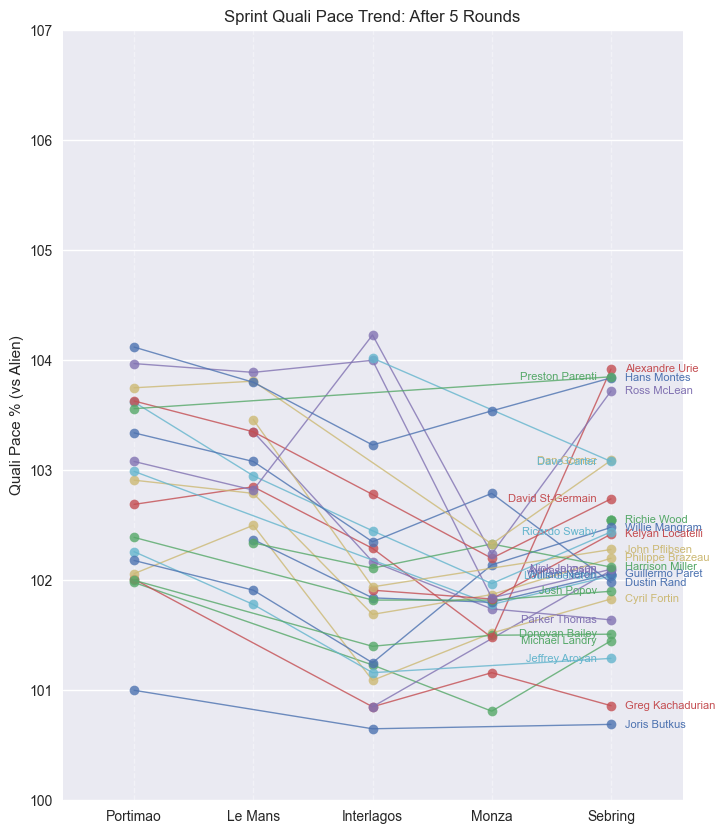

In [23]:
plt.style.use('seaborn-v0_8')

col_best = 'Best Quali Pace % (vs Alien)'
col1 = 'Portimao Quali Pace % (vs Alien)'
col2 = 'Le Mans Quali Pace % (vs Alien)'
col3 = 'Interlagos Quali Pace % (vs Alien)'
col4 = 'Monza Quali Pace % (vs Alien)'
col5 = 'Sebring Quali Pace % (vs Alien)'

time_lower = 100.0
time_upper = 107.0

# Build plot_df with friendly column names (keeps existing behavior)
plot_df = df2[['Driver_name',col_best, col1, col2, col3, col4, col5]].copy().rename(columns={col1: 'Portimao', col2: 'Le Mans', col3: 'Interlagos', col4: 'Monza', col5: 'Sebring'})
# Keep filter logic from before
plot_df = plot_df[plot_df[plot_df.columns[-1]].between(time_lower, time_upper)].reset_index(drop=True)
plot_df['best'] = plot_df[['Portimao', 'Le Mans', 'Interlagos', 'Monza', 'Sebring']].min(axis=1, skipna=True)
plot_df = plot_df.sort_values('best').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 10))
# Track columns are dynamic now — just list the display columns in order
track_cols = ['Portimao', 'Le Mans', 'Interlagos', 'Monza', 'Sebring']
x_positions = list(range(len(track_cols)))

# set ticks once
ax.set_xticks(x_positions)
ax.set_xticklabels(track_cols)

for idx, (_, row) in enumerate(plot_df.iterrows()):
    # collect available (x, y) points for this driver dynamically
    pts = []
    for xi, col in enumerate(track_cols):
        val = row.get(col)
        if pd.notna(val):
            pts.append((xi, val))

    if not pts:
        continue

    xs, ys = zip(*pts)

    # draw a single line through all present points; falls back to a single marker for single point
    if len(pts) > 1:
        line = ax.plot(xs, ys, marker='o', lw=1, alpha=0.8)
        color = line[0].get_color()
    else:
        sc = ax.scatter(xs[0], ys[0], marker='o')
        color = sc.get_facecolor()[0]

    # Alternate label placement to avoid overlap
    x_offset = 0.12 if idx % 2 == 0 else -0.12
    ha_align = 'left' if idx % 2 == 0 else 'right'

    # place the label at the last available point (rightmost) — works for any combination
    label_x = xs[-1] + x_offset
    label_y = ys[-1]
    ax.text(label_x, label_y, row['Driver_name'], va='center', ha=ha_align, fontsize=8, color=color)

ax.set_ylabel('Quali Pace % (vs Alien)')
ax.set_title('Sprint Quali Pace Trend: After 5 Rounds')
ax.grid(axis='x', linestyle='--', alpha=0.4)
plt.xlim(-0.6, len(track_cols) - 1 + 0.6)
plt.ylim(time_lower, time_upper)
plt.show()

In [25]:
import plotly.graph_objects as go
import plotly.express as px

col_best = 'Best Quali Pace % (vs Alien)'
col1 = 'Portimao Quali Pace % (vs Alien)'
col2 = 'Le Mans Quali Pace % (vs Alien)'
col3 = 'Interlagos Quali Pace % (vs Alien)'
col4 = 'Monza Quali Pace % (vs Alien)'
col5 = 'Sebring Quali Pace % (vs Alien)'

time_lower = 100.0
time_upper = 107.0

# Build plot_df with friendly column names
plot_df = df2[['Driver_name', col_best, col1, col2, col3, col4, col5]].copy().rename(
    columns={col1: 'Portimao', col2: 'Le Mans', col3: 'Interlagos', col4: 'Monza', col5: 'Sebring'}
)
# Keep filter logic
plot_df = plot_df[plot_df[plot_df.columns[-1]].between(time_lower, time_upper)].reset_index(drop=True)
plot_df['best'] = plot_df[['Portimao', 'Le Mans', 'Interlagos', 'Monza', 'Sebring']].min(axis=1, skipna=True)
plot_df = plot_df.sort_values('best').reset_index(drop=True)

# Create Plotly figure
fig = go.Figure()

track_cols = ['Portimao', 'Le Mans', 'Interlagos', 'Monza', 'Sebring']
x_positions = list(range(len(track_cols)))

for idx, (_, row) in enumerate(plot_df.iterrows()):
    # Collect available (x, y) points for this driver
    pts = []
    for xi, col in enumerate(track_cols):
        val = row.get(col)
        if pd.notna(val):
            pts.append((xi, val))
    
    if not pts:
        continue
    
    xs, ys = list(zip(*pts))
    
    # Add line trace
    fig.add_trace(go.Scatter(
        x=xs,
        y=ys,
        mode='lines+markers',
        name=row['Driver_name'],
        hovertemplate='<b>' + row['Driver_name'] + '</b><br>%{customdata}<br>Pace: %{y:.2f}%<extra></extra>',
        customdata=[track_cols[int(i)] for i in xs],
        line=dict(width=2),
        marker=dict(size=8)
    ))

fig.update_layout(
    title='Sprint Quali Pace Trend: After 5 Rounds',
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1,
        ticktext=track_cols,
        tickvals=x_positions
    ),
    yaxis_title='Quali Pace % (vs Alien)',
    hovermode='closest',
    plot_bgcolor='rgba(240, 240, 240, 0.5)',
    height=700,
    width=1000,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255, 255, 255, 0.8)"
    )
)

fig.update_yaxes(range=[time_lower, time_upper])
fig.update_xaxes(range=[-0.6, len(track_cols) - 1 + 0.6])

# Save to HTML
fig.write_html('sprint_quali_pace_trend.html')
print("✓ Interactive plot saved to 'sprint_quali_pace_trend.html'")

# Display in notebook
fig.show()

✓ Interactive plot saved to 'sprint_quali_pace_trend.html'


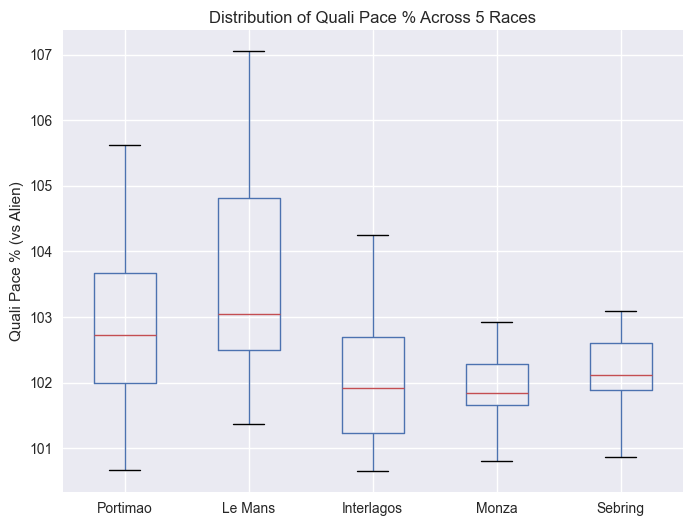

In [46]:
# boxplot of driver pace (laptime_pct_alien) across 4 races
cols = {
    'Portimao': df1_sc1['laptime_pct_alien'].replace([np.inf, 0], np.nan).reset_index(drop=True),
    'Le Mans': df1_sc2['laptime_pct_alien'].replace([np.inf, 0], np.nan).reset_index(drop=True),
    'Interlagos': df1_sc3['laptime_pct_alien'].replace([np.inf, 0], np.nan).reset_index(drop=True),
    'Monza': df1_sc4['laptime_pct_alien'].replace([np.inf, 0], np.nan).reset_index(drop=True),
    'Sebring': df1_sc5['laptime_pct_alien'].replace([np.inf, 0], np.nan).reset_index(drop=True)
}
box_df = pd.DataFrame(cols)

fig, ax = plt.subplots(figsize=(8, 6))
box_df.boxplot(ax=ax, grid=True, showfliers=False)
ax.set_ylabel('Quali Pace % (vs Alien)')
ax.set_title('Distribution of Quali Pace % Across 5 Races')
plt.show()